In [127]:
import time
import numpy as np
import torch

import src.utils as ut
from src.SCMMappings_1_1 import Abstraction
from src.printing import AbstractionPrinter

import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork as BN
from pgmpy.factors.discrete import TabularCPD as cpd

In [128]:
seed = 0
np.random.seed(seed)  # Numpy module
torch.manual_seed(seed)

In [129]:
from src.examples import smokingmodels as ex

In [130]:
A_basic = Abstraction(*ex.basic_lung_cancer())
A_collapsing = Abstraction(*ex.collapsing_lung_cancer())
A_extended = Abstraction(*ex.extended_lung_cancer())
A_vstruct = Abstraction(*ex.vstruct_lung_cancer())


In [131]:
import src.evaluationsets as es
import src.learning as lng

In [132]:
J_basic = es.get_causal_sets_in_M1_with_directed_path_in_M1_and_M0(A_basic.M0, A_basic.M1, A_basic.a)

In [133]:
J_collapsing = [[['Smoking_'], ['Tar_']],
 [['Smoking_'], ['Cancer_']],
 [['Tar_'], ['Cancer_']]]

In [134]:
J_extended = [[['Smoking_'], ['Tar_']],
 [['Smoking_'], ['Cancer_']],
 [['Tar_'], ['Cancer_']]]

In [135]:
J_vstruct = [[['Smoking_'], ['Cancer_']],
 [['Smoking_'], ['Fatigue_']],
 [['Cancer_'], ['Fatigue_']]]

In [136]:
from src.nn import JointNeuralNet
from src.nn_losses import JSD_loss,RowMax_penalty

In [137]:
def calc_distance(Ws, alpha_index, alphas):
    distance = 0.0
    for key, value in alpha_index.items():
        distance += torch.sum(torch.abs(torch.from_numpy(alphas[key])-Ws[value]))
    return distance

In [138]:

def train_a_IndepNN_model(M0,M1,R,a,alphas,J,Ws,T,lmbda,num_epochs,lr):
    distances = np.zeros((num_epochs))
    jsds = np.zeros((num_epochs))
    pens = np.zeros((num_epochs))
    end_results = {}
    aggregate_alphas = {}

    for j in J:
        model = JointNeuralNet(M0,M1,R,a,[j],T)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion_jsd = JSD_loss()
        criterion_pen = RowMax_penalty()

        for epoch in range(num_epochs):
            lowpaths, highpaths, Ws = model()    
            loss_jsd = criterion_jsd(lowpaths, highpaths)
            loss_pen = criterion_pen(Ws)
            loss = lmbda*loss_jsd + loss_pen
            
            distances[epoch] += calc_distance(Ws, model.alpha_index, alphas)
            jsds[epoch] += loss_jsd
            pens[epoch] += loss_pen

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (epoch+1) % 500 == 0:
                print ('Epoch [{}/{}], Loss: {:.4f}, JSD: {:.4f}, Penalty: {:.4f}'.format(epoch+1, num_epochs, loss, loss_jsd, loss_pen))
        

        for name in model.alphas_to_learn:
            if name in aggregate_alphas:
                aggregate_alphas[name] += model.get_Wmatrix_by_name(name).detach()
            else:
                aggregate_alphas[name] = model.get_Wmatrix_by_name(name).detach()
                
    # normalise
    normalised_alphas = {}
    for name, value in aggregate_alphas.items():
        normalised_alphas[name] = torch.exp(value) / torch.unsqueeze(torch.sum(torch.exp(value),axis=0),dim=0)
    
    # discretize alphas and calc_distance
    discretized_alphas = {}
    for name, value in normalised_alphas.items():
        tmp = torch.zeros((value.shape))
        for i in range(value.shape[1]):
            tmp[torch.argmax(value[:,i]),i] = 1
        discretized_alphas[name] = tmp
    
    #calculate distance with discrete learnt alphas
    end_distance = 0.0
    for key, value in alphas.items():
        end_distance += torch.sum(torch.abs(torch.from_numpy(alphas[key])-discretized_alphas[key]))
    
    # jsd and penalty with initalised discrete alphas
    criterion_jsd = JSD_loss()
    criterion_pen = RowMax_penalty()
    end_model = JointNeuralNet(M0,M1,R,a,J,T,initialised_alphas=discretized_alphas)
    lowpaths, highpaths, Ws = end_model()    
    end_loss_jsd = criterion_jsd(lowpaths, highpaths)
    end_loss_pen = criterion_pen(Ws)
    
    # store end results
    end_results['normalised_alphas'] = normalised_alphas
    end_results['discretized_alpha'] = discretized_alphas
    end_results['jsd'] = end_loss_jsd
    end_results['penalty'] = end_loss_pen
    end_results['distance'] = end_distance
    
    
    return distances/(len(J)*2.0), jsds/len(J), pens/(len(J)*2.0), end_results

In [139]:
lr = 0.01
num_epochs = 500
T = 0.1
lmbda=10.0
n_fold = 10
k_fold = 10

In [140]:
n_best_distance1 = np.zeros((n_fold,num_epochs))
n_best_jsd1 = np.zeros((n_fold,num_epochs))
n_best_pen1 = np.zeros((n_fold,num_epochs))
n_best_end_results1 = []
n_time1 = np.zeros((n_fold))

n_best_distance2 = np.zeros((n_fold,num_epochs))
n_best_jsd2 = np.zeros((n_fold,num_epochs))
n_best_pen2 = np.zeros((n_fold,num_epochs))
n_best_end_results2 = []
n_time2 = np.zeros((n_fold))

n_best_distance3 = np.zeros((n_fold,num_epochs))
n_best_jsd3 = np.zeros((n_fold,num_epochs))
n_best_pen3 = np.zeros((n_fold,num_epochs))
n_best_end_results3 = []
n_time3 = np.zeros((n_fold))

n_best_distance4 = np.zeros((n_fold,num_epochs))
n_best_jsd4 = np.zeros((n_fold,num_epochs))
n_best_pen4 = np.zeros((n_fold,num_epochs))
n_best_end_results4 = []
n_time4 = np.zeros((n_fold))


for n in range(n_fold):
    print(f"n fold {n+1}:")

    k_distances1 = np.zeros((k_fold,num_epochs))
    k_jsds1 = np.zeros((k_fold,num_epochs))
    k_pens1 = np.zeros((k_fold,num_epochs))
    k_end_results1 = []
    k_time1 = np.zeros((k_fold))
    
    k_distances2 = np.zeros((k_fold,num_epochs))
    k_jsds2 = np.zeros((k_fold,num_epochs))
    k_pens2 = np.zeros((k_fold,num_epochs))
    k_end_results2 = []
    k_time2 = np.zeros((k_fold))
    
    k_distances3 = np.zeros((k_fold,num_epochs))
    k_jsds3 = np.zeros((k_fold,num_epochs))
    k_pens3 = np.zeros((k_fold,num_epochs))
    k_end_results3 = []
    k_time3 = np.zeros((k_fold))
    
    k_distances4 = np.zeros((k_fold,num_epochs))
    k_jsds4 = np.zeros((k_fold,num_epochs))
    k_pens4 = np.zeros((k_fold,num_epochs))
    k_end_results4 = []
    k_time4 = np.zeros((k_fold))
    
    for fold in range(k_fold):
        st = time.time()
        distances_epoch1, jsds1, pens1, end_results1 = train_a_IndepNN_model(A_basic.M0, A_basic.M1, A_basic.R, A_basic.a, A_basic.alphas, J_basic,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time1 = et - st
        
        st = time.time()
        distances_epoch2, jsds2, pens2, end_results2 = train_a_IndepNN_model(A_collapsing.M0, A_collapsing.M1, A_collapsing.R, A_collapsing.a, A_collapsing.alphas, J_collapsing,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time2 = et - st
        
        st = time.time()
        distances_epoch3, jsds3, pens3, end_results3 = train_a_IndepNN_model(A_extended.M0, A_extended.M1, A_extended.R, A_extended.a, A_extended.alphas, J_extended,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time3 = et - st
        
        st = time.time()
        distances_epoch4, jsds4, pens4, end_results4 = train_a_IndepNN_model(A_vstruct.M0, A_vstruct.M1, A_vstruct.R, A_vstruct.a, A_vstruct.alphas, J_vstruct,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time4 = et - st
        
        
        k_distances1[fold] = distances_epoch1
        k_jsds1[fold] = jsds1
        k_pens1[fold] = pens1
        k_end_results1.append(end_results1)
        k_time1[fold] = time1
        
        k_distances2[fold] = distances_epoch2
        k_jsds2[fold] = jsds2
        k_pens2[fold] = pens2
        k_end_results2.append(end_results2)
        k_time2[fold] = time2
        
        k_distances3[fold] = distances_epoch3
        k_jsds3[fold] = jsds3
        k_pens3[fold] = pens3
        k_end_results3.append(end_results3)
        k_time3[fold] = time3
        
        k_distances4[fold] = distances_epoch4
        k_jsds4[fold] = jsds4
        k_pens4[fold] = pens4
        k_end_results4.append(end_results4)
        k_time4[fold] = time4
        
    k_losses1 = k_jsds1+k_pens1
    k_losses2 = k_jsds2+k_pens2
    k_losses3 = k_jsds3+k_pens3
    k_losses4 = k_jsds4+k_pens4
    best1 = np.argmin(k_losses1[:,-1])
    best2 = np.argmin(k_losses2[:,-1])
    best3 = np.argmin(k_losses3[:,-1])
    best4 = np.argmin(k_losses4[:,-1])
    
    n_best_distance1[n] = k_distances1[best1]
    n_best_jsd1[n] = k_jsds1[best1]
    n_best_pen1[n] = k_pens1[best1]
    n_best_end_results1.append(k_end_results1[best1])
    n_time1[n] = k_time1[best1]
    
    n_best_distance2[n] = k_distances2[best2]
    n_best_jsd2[n] = k_jsds2[best2]
    n_best_pen2[n] = k_pens2[best2]
    n_best_end_results2.append(k_end_results2[best2])
    n_time2[n] = k_time2[best2]
    
    n_best_distance3[n] = k_distances3[best3]
    n_best_jsd3[n] = k_jsds3[best3]
    n_best_pen3[n] = k_pens3[best3]
    n_best_end_results3.append(k_end_results3[best3])
    n_time3[n] = k_time3[best3]
    
    n_best_distance4[n] = k_distances4[best4]
    n_best_jsd4[n] = k_jsds4[best4]
    n_best_pen4[n] = k_pens4[best4]
    n_best_end_results4.append(k_end_results4[best4])
    n_time4[n] = k_time4[best4]
        
        

n fold 1:
Epoch [500/500], Loss: 0.0046, JSD: 0.0004, Penalty: 0.0006
Epoch [500/500], Loss: 0.4265, JSD: 0.0063, Penalty: 0.3638
Epoch [500/500], Loss: 1.2667, JSD: 0.0029, Penalty: 1.2373
Epoch [500/500], Loss: 0.0060, JSD: 0.0004, Penalty: 0.0020
Epoch [500/500], Loss: 0.8032, JSD: 0.0688, Penalty: 0.1154
Epoch [500/500], Loss: 0.4674, JSD: 0.0409, Penalty: 0.0586
Epoch [500/500], Loss: 0.0088, JSD: 0.0005, Penalty: 0.0039
Epoch [500/500], Loss: 0.8506, JSD: 0.0026, Penalty: 0.8242
Epoch [500/500], Loss: 1.1718, JSD: 0.0171, Penalty: 1.0011
Epoch [500/500], Loss: 0.1451, JSD: 0.0006, Penalty: 0.1392
Epoch [500/500], Loss: 1.2610, JSD: 0.0048, Penalty: 1.2132
Epoch [500/500], Loss: 0.0719, JSD: 0.0010, Penalty: 0.0619
Epoch [500/500], Loss: 0.0727, JSD: 0.0010, Penalty: 0.0630
Epoch [500/500], Loss: 0.0059, JSD: 0.0005, Penalty: 0.0013
Epoch [500/500], Loss: 0.8033, JSD: 0.0687, Penalty: 0.1159
Epoch [500/500], Loss: 0.6452, JSD: 0.0589, Penalty: 0.0565
Epoch [500/500], Loss: 1.3410,

Epoch [500/500], Loss: 0.7853, JSD: 0.0019, Penalty: 0.7660
Epoch [500/500], Loss: 0.0214, JSD: 0.0021, Penalty: 0.0006
Epoch [500/500], Loss: 0.0038, JSD: 0.0004, Penalty: 0.0001
Epoch [500/500], Loss: 1.2625, JSD: 0.0041, Penalty: 1.2218
Epoch [500/500], Loss: 0.4775, JSD: 0.0102, Penalty: 0.3758
Epoch [500/500], Loss: 0.0696, JSD: 0.0008, Penalty: 0.0614
Epoch [500/500], Loss: 1.1667, JSD: 0.0081, Penalty: 1.0861
Epoch [500/500], Loss: 1.4716, JSD: 0.0041, Penalty: 1.4310
Epoch [500/500], Loss: 0.5890, JSD: 0.0252, Penalty: 0.3365
Epoch [500/500], Loss: 0.3877, JSD: 0.0216, Penalty: 0.1716
Epoch [500/500], Loss: 0.7686, JSD: 0.0014, Penalty: 0.7546
Epoch [500/500], Loss: 0.3913, JSD: 0.0049, Penalty: 0.3423
Epoch [500/500], Loss: 0.0198, JSD: 0.0015, Penalty: 0.0045
Epoch [500/500], Loss: 1.7042, JSD: 0.0989, Penalty: 0.7155
Epoch [500/500], Loss: 2.3256, JSD: 0.2289, Penalty: 0.0364
Epoch [500/500], Loss: 0.0728, JSD: 0.0011, Penalty: 0.0616
Epoch [500/500], Loss: 1.1268, JSD: 0.00

Epoch [500/500], Loss: 1.3090, JSD: 0.0087, Penalty: 1.2215
Epoch [500/500], Loss: 0.8375, JSD: 0.0468, Penalty: 0.3700
Epoch [500/500], Loss: 0.2928, JSD: 0.0011, Penalty: 0.2822
Epoch [500/500], Loss: 0.8502, JSD: 0.0014, Penalty: 0.8360
Epoch [500/500], Loss: 0.0164, JSD: 0.0016, Penalty: 0.0005
Epoch [500/500], Loss: 0.0115, JSD: 0.0011, Penalty: 0.0004
Epoch [500/500], Loss: 0.0036, JSD: 0.0004, Penalty: 0.0000
Epoch [500/500], Loss: 0.4432, JSD: 0.0080, Penalty: 0.3637
Epoch [500/500], Loss: 0.1612, JSD: 0.0151, Penalty: 0.0098
Epoch [500/500], Loss: 1.1472, JSD: 0.0055, Penalty: 1.0918
Epoch [500/500], Loss: 0.0091, JSD: 0.0006, Penalty: 0.0028
Epoch [500/500], Loss: 0.6728, JSD: 0.0290, Penalty: 0.3829
Epoch [500/500], Loss: 1.3392, JSD: 0.1195, Penalty: 0.1441
Epoch [500/500], Loss: 0.8631, JSD: 0.0052, Penalty: 0.8110
Epoch [500/500], Loss: 0.7004, JSD: 0.0700, Penalty: 0.0002
Epoch [500/500], Loss: 0.4209, JSD: 0.0012, Penalty: 0.4086
Epoch [500/500], Loss: 0.0060, JSD: 0.00

Epoch [500/500], Loss: 2.0135, JSD: 0.0014, Penalty: 2.0000
Epoch [500/500], Loss: 0.0720, JSD: 0.0014, Penalty: 0.0577
Epoch [500/500], Loss: 2.0053, JSD: 0.0021, Penalty: 1.9840
Epoch [500/500], Loss: 1.0135, JSD: 0.0023, Penalty: 0.9903
Epoch [500/500], Loss: 0.9659, JSD: 0.0961, Penalty: 0.0048
Epoch [500/500], Loss: 0.0053, JSD: 0.0004, Penalty: 0.0009
Epoch [500/500], Loss: 0.8424, JSD: 0.0015, Penalty: 0.8271
Epoch [500/500], Loss: 0.7827, JSD: 0.0779, Penalty: 0.0034
Epoch [500/500], Loss: 0.1862, JSD: 0.0020, Penalty: 0.1659
Epoch [500/500], Loss: 2.0148, JSD: 0.0835, Penalty: 1.1794
Epoch [500/500], Loss: 0.0744, JSD: 0.0007, Penalty: 0.0670
Epoch [500/500], Loss: 1.4637, JSD: 0.1263, Penalty: 0.2006
Epoch [500/500], Loss: 2.1774, JSD: 0.0228, Penalty: 1.9491
Epoch [500/500], Loss: 0.0095, JSD: 0.0006, Penalty: 0.0037
Epoch [500/500], Loss: 0.8152, JSD: 0.0434, Penalty: 0.3809
Epoch [500/500], Loss: 0.2919, JSD: 0.0012, Penalty: 0.2804
Epoch [500/500], Loss: 0.7735, JSD: 0.00

Epoch [500/500], Loss: 0.0235, JSD: 0.0023, Penalty: 0.0000
Epoch [500/500], Loss: 0.7433, JSD: 0.0015, Penalty: 0.7282
Epoch [500/500], Loss: 1.7032, JSD: 0.0016, Penalty: 1.6871
Epoch [500/500], Loss: 0.4375, JSD: 0.0051, Penalty: 0.3862
Epoch [500/500], Loss: 0.0702, JSD: 0.0007, Penalty: 0.0637
Epoch [500/500], Loss: 0.0047, JSD: 0.0004, Penalty: 0.0004
Epoch [500/500], Loss: 1.0748, JSD: 0.0578, Penalty: 0.4971
Epoch [500/500], Loss: 1.0813, JSD: 0.1057, Penalty: 0.0244
Epoch [500/500], Loss: 1.5019, JSD: 0.1190, Penalty: 0.3119
Epoch [500/500], Loss: 0.8383, JSD: 0.0010, Penalty: 0.8284
Epoch [500/500], Loss: 0.3271, JSD: 0.0018, Penalty: 0.3088
Epoch [500/500], Loss: 0.1187, JSD: 0.0006, Penalty: 0.1129
Epoch [500/500], Loss: 0.0120, JSD: 0.0005, Penalty: 0.0072
Epoch [500/500], Loss: 0.0757, JSD: 0.0012, Penalty: 0.0640
Epoch [500/500], Loss: 1.3869, JSD: 0.0187, Penalty: 1.2003
Epoch [500/500], Loss: 0.0053, JSD: 0.0004, Penalty: 0.0016
Epoch [500/500], Loss: 0.9242, JSD: 0.00

Epoch [500/500], Loss: 0.8640, JSD: 0.0864, Penalty: 0.0000
Epoch [500/500], Loss: 0.0048, JSD: 0.0005, Penalty: 0.0000
Epoch [500/500], Loss: 0.8292, JSD: 0.0100, Penalty: 0.7289
Epoch [500/500], Loss: 0.0127, JSD: 0.0013, Penalty: 0.0001
Epoch [500/500], Loss: 0.1499, JSD: 0.0013, Penalty: 0.1374
Epoch [500/500], Loss: 1.7067, JSD: 0.0017, Penalty: 1.6897
Epoch [500/500], Loss: 0.0714, JSD: 0.0007, Penalty: 0.0642
Epoch [500/500], Loss: 0.0682, JSD: 0.0008, Penalty: 0.0601
Epoch [500/500], Loss: 1.1598, JSD: 0.0080, Penalty: 1.0797
Epoch [500/500], Loss: 0.9121, JSD: 0.0026, Penalty: 0.8861
Epoch [500/500], Loss: 0.8641, JSD: 0.0864, Penalty: 0.0002
Epoch [500/500], Loss: 1.3406, JSD: 0.1195, Penalty: 0.1455
Epoch [500/500], Loss: 0.8903, JSD: 0.0024, Penalty: 0.8665
Epoch [500/500], Loss: 0.4210, JSD: 0.0420, Penalty: 0.0008
Epoch [500/500], Loss: 0.0061, JSD: 0.0005, Penalty: 0.0016
n fold 8:
Epoch [500/500], Loss: 0.0072, JSD: 0.0005, Penalty: 0.0024
Epoch [500/500], Loss: 0.0732,

Epoch [500/500], Loss: 1.6748, JSD: 0.0566, Penalty: 1.1088
Epoch [500/500], Loss: 4.3035, JSD: 0.3303, Penalty: 1.0000
Epoch [500/500], Loss: 0.9552, JSD: 0.0092, Penalty: 0.8635
Epoch [500/500], Loss: 0.8283, JSD: 0.0451, Penalty: 0.3772
Epoch [500/500], Loss: 0.3025, JSD: 0.0028, Penalty: 0.2749
Epoch [500/500], Loss: 0.7729, JSD: 0.0010, Penalty: 0.7624
Epoch [500/500], Loss: 0.0161, JSD: 0.0015, Penalty: 0.0008
Epoch [500/500], Loss: 0.1887, JSD: 0.0004, Penalty: 0.1846
Epoch [500/500], Loss: 0.0063, JSD: 0.0004, Penalty: 0.0022
Epoch [500/500], Loss: 0.4158, JSD: 0.0054, Penalty: 0.3620
Epoch [500/500], Loss: 1.7042, JSD: 0.1453, Penalty: 0.2511
Epoch [500/500], Loss: 1.1585, JSD: 0.0072, Penalty: 1.0860
Epoch [500/500], Loss: 0.4957, JSD: 0.0071, Penalty: 0.4248
Epoch [500/500], Loss: 1.1417, JSD: 0.0802, Penalty: 0.3395
Epoch [500/500], Loss: 1.3389, JSD: 0.1198, Penalty: 0.1406
Epoch [500/500], Loss: 0.8428, JSD: 0.0016, Penalty: 0.8264
Epoch [500/500], Loss: 0.0121, JSD: 0.00

Epoch [500/500], Loss: 0.1298, JSD: 0.0022, Penalty: 0.1073
Epoch [500/500], Loss: 2.0044, JSD: 0.0110, Penalty: 1.8949
Epoch [500/500], Loss: 1.3178, JSD: 0.1314, Penalty: 0.0036
Epoch [500/500], Loss: 0.1753, JSD: 0.0159, Penalty: 0.0160
Epoch [500/500], Loss: 1.1412, JSD: 0.0020, Penalty: 1.1212
Epoch [500/500], Loss: 0.6747, JSD: 0.0233, Penalty: 0.4412
Epoch [500/500], Loss: 0.7132, JSD: 0.0705, Penalty: 0.0085
Epoch [500/500], Loss: 0.0095, JSD: 0.0005, Penalty: 0.0050
Epoch [500/500], Loss: 0.8863, JSD: 0.0088, Penalty: 0.7981
Epoch [500/500], Loss: 0.7009, JSD: 0.0701, Penalty: 0.0003
Epoch [500/500], Loss: 0.4183, JSD: 0.0004, Penalty: 0.4138
Epoch [500/500], Loss: 1.2615, JSD: 0.0030, Penalty: 1.2318
Epoch [500/500], Loss: 0.3963, JSD: 0.0032, Penalty: 0.3642
Epoch [500/500], Loss: 0.0692, JSD: 0.0008, Penalty: 0.0608
Epoch [500/500], Loss: 2.1841, JSD: 0.0795, Penalty: 1.3888
Epoch [500/500], Loss: 0.4952, JSD: 0.0070, Penalty: 0.4252
Epoch [500/500], Loss: 0.0053, JSD: 0.00

In [141]:
avg_dis1 = np.mean(n_best_distance1,axis=0)
avg_dis_err1 = np.std(n_best_distance1,axis=0)

avg_jsd1 = np.mean(n_best_jsd1,axis=0)
avg_jsd_err1 = np.std(n_best_jsd1,axis=0)

avg_pen1 = np.mean(n_best_pen1,axis=0)
avg_pen_err1 = np.std(n_best_pen1,axis=0)

avg_time1 = np.mean(n_time1,axis=0)
avg_time_err1 = np.std(n_time1,axis=0)

print(f"Basic: Avg Alpha distance: {avg_dis1[-1]}")
print(f"Basic: Avg JSD: {avg_jsd1[-1]}")
print(f"Basic: Avg Penalty: {avg_pen1[-1]}")
print(f"Basic: Avg Time: {avg_time1}")
print(f"Basic: Avg Alpha distance SD: {avg_dis_err1[-1]}")
print(f"Basic: Avg JSD SD: {avg_jsd_err1[-1]}")
print(f"Basic: Avg Penalty SD: {avg_pen_err1[-1]}")
print(f"Basic: Avg Time SD: {avg_time_err1}")


avg_dis2 = np.mean(n_best_distance2,axis=0)
avg_dis_err2 = np.std(n_best_distance2,axis=0)

avg_jsd2 = np.mean(n_best_jsd2,axis=0)
avg_jsd_err2 = np.std(n_best_jsd2,axis=0)

avg_pen2 = np.mean(n_best_pen2,axis=0)
avg_pen_err2 = np.std(n_best_pen2,axis=0)

avg_time2 = np.mean(n_time2,axis=0)
avg_time_err2 = np.std(n_time2,axis=0)

print(f"Collapsing: Avg Alpha distance: {avg_dis2[-1]}")
print(f"Collapsing: Avg JSD: {avg_jsd2[-1]}")
print(f"Collapsing: Avg Penalty: {avg_pen2[-1]}")
print(f"Collapsing: Avg Time: {avg_time2}")
print(f"Collapsing: Avg Alpha distance SD: {avg_dis_err2[-1]}")
print(f"Collapsing: Avg JSD SD: {avg_jsd_err2[-1]}")
print(f"Collapsing: Avg Penalty SD: {avg_pen_err2[-1]}")
print(f"Collapsing: Avg Time SD: {avg_time_err2}")


avg_dis3 = np.mean(n_best_distance3,axis=0)
avg_dis_err3 = np.std(n_best_distance3,axis=0)

avg_jsd3 = np.mean(n_best_jsd3,axis=0)
avg_jsd_err3 = np.std(n_best_jsd3,axis=0)

avg_pen3 = np.mean(n_best_pen3,axis=0)
avg_pen_err3 = np.std(n_best_pen3,axis=0)

avg_time3 = np.mean(n_time3,axis=0)
avg_time_err3 = np.std(n_time3,axis=0)

print(f"Extended: Avg Alpha distance: {avg_dis3[-1]}")
print(f"Extended: Avg JSD: {avg_jsd3[-1]}")
print(f"Extended: Avg Penalty: {avg_pen3[-1]}")
print(f"Extended: Avg Time: {avg_time3}")
print(f"Extended: Avg Alpha distance SD: {avg_dis_err3[-1]}")
print(f"Extended: Avg JSD SD: {avg_jsd_err3[-1]}")
print(f"Extended: Avg Penalty SD: {avg_pen_err3[-1]}")
print(f"Extended: Avg Time SD: {avg_time_err3}")


avg_dis4 = np.mean(n_best_distance4,axis=0)
avg_dis_err4 = np.std(n_best_distance4,axis=0)

avg_jsd4 = np.mean(n_best_jsd4,axis=0)
avg_jsd_err4 = np.std(n_best_jsd4,axis=0)

avg_pen4 = np.mean(n_best_pen4,axis=0)
avg_pen_err4 = np.std(n_best_pen4,axis=0)

avg_time4 = np.mean(n_time4,axis=0)
avg_time_err4 = np.std(n_time4,axis=0)

print(f"Vstruct: Avg Alpha distance: {avg_dis4[-1]}")
print(f"Vstruct: Avg JSD: {avg_jsd4[-1]}")
print(f"Vstruct: Avg Penalty: {avg_pen4[-1]}")
print(f"Vstruct: Avg Time: {avg_time4}")
print(f"Vstruct: Avg Alpha distance SD: {avg_dis_err4[-1]}")
print(f"Vstruct: Avg JSD SD: {avg_jsd_err4[-1]}")
print(f"Vstruct: Avg Penalty SD: {avg_pen_err4[-1]}")
print(f"Vstruct: Avg Time SD: {avg_time_err4}")

Basic: Avg Alpha distance: 0.0003197041309012688
Basic: Avg JSD: 0.0004388169531011954
Basic: Avg Penalty: 0.0001598447561264038
Basic: Avg Time: 0.44515485763549806
Basic: Avg Alpha distance SD: 0.00038284643109300255
Basic: Avg JSD SD: 4.110474353757939e-05
Basic: Avg Penalty SD: 0.00019142396098485544
Basic: Avg Time SD: 0.0023749673052739714
Collapsing: Avg Alpha distance: 0.6697375373568765
Collapsing: Avg JSD: 0.015055410540662704
Collapsing: Avg Penalty: 0.04911459783713022
Collapsing: Avg Time: 1.3405762910842896
Collapsing: Avg Alpha distance SD: 1.0160097231554075
Collapsing: Avg JSD SD: 0.03872967359722674
Collapsing: Avg Penalty SD: 0.05867048184465949
Collapsing: Avg Time SD: 0.004733603172729116
Extended: Avg Alpha distance: 2.16759975751241
Extended: Avg JSD: 0.031388737509648004
Extended: Avg Penalty: 0.04497077067693075
Extended: Avg Time: 1.348029899597168
Extended: Avg Alpha distance SD: 0.9404235060527455
Extended: Avg JSD SD: 0.01936396733137627
Extended: Avg Penal

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


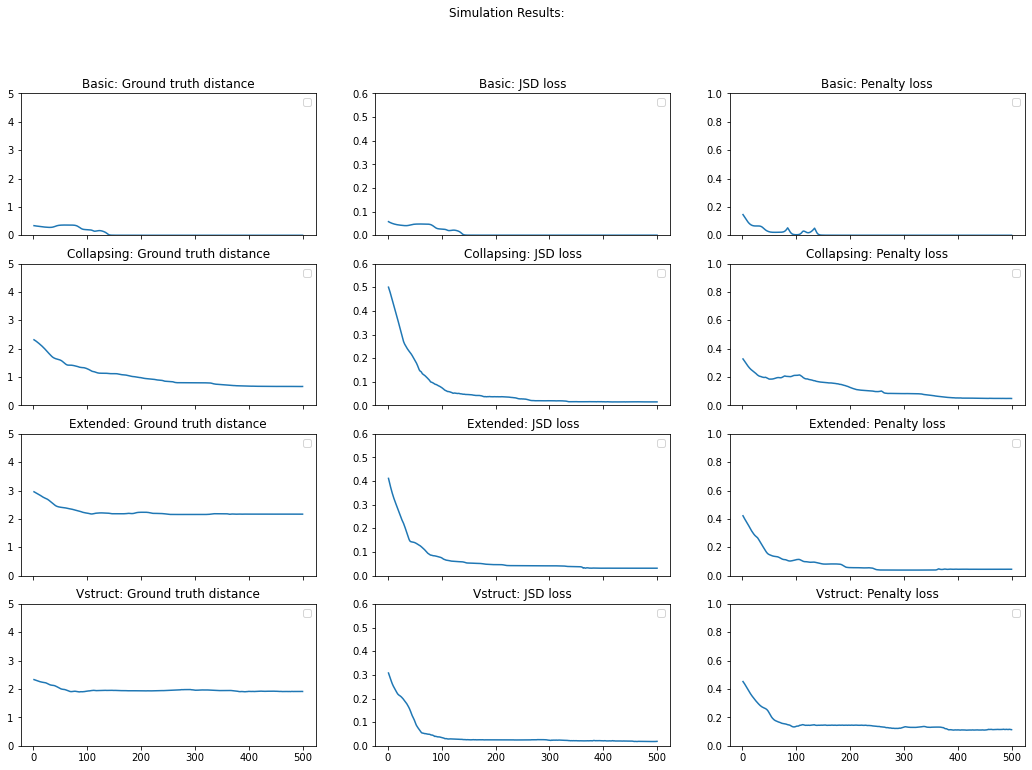

In [147]:

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8), (ax9, ax10, ax11)) = plt.subplots(nrows=4, ncols=3, sharex=True,
                                    figsize=(18, 12))
time_epoch = np.array([i+1 for i in range(num_epochs)])
ax0.set_title('Basic: Ground truth distance')
ax0.plot(time_epoch, avg_dis1)
ax0.set_ylim([0,5])
ax0.legend()

ax1.set_title('Basic: JSD loss')
ax1.plot(time_epoch, avg_jsd1)
ax1.set_ylim([0,0.6])
ax1.legend()

ax2.set_title('Basic: Penalty loss')
ax2.plot(time_epoch, avg_pen1)
ax2.set_ylim([0,1])
ax2.legend()

ax3.set_title('Collapsing: Ground truth distance')
ax3.plot(time_epoch, avg_dis2)
ax3.set_ylim([0,5])
ax3.legend()

ax4.set_title('Collapsing: JSD loss')
ax4.plot(time_epoch, avg_jsd2)
ax4.set_ylim([0,0.6])
ax4.legend()

ax5.set_title('Collapsing: Penalty loss')
ax5.plot(time_epoch, avg_pen2)
ax5.set_ylim([0,1])
ax5.legend()

ax6.set_title('Extended: Ground truth distance')
ax6.plot(time_epoch, avg_dis3)
ax6.set_ylim([0,5])
ax6.legend()

ax7.set_title('Extended: JSD loss')
ax7.plot(time_epoch, avg_jsd3)
ax7.set_ylim([0,0.6])
ax7.legend()

ax8.set_title('Extended: Penalty loss')
ax8.plot(time_epoch, avg_pen3)
ax8.set_ylim([0,1])
ax8.legend()

ax9.set_title('Vstruct: Ground truth distance')
ax9.plot(time_epoch, avg_dis4)
ax9.set_ylim([0,5])
ax9.legend()

ax10.set_title('Vstruct: JSD loss')
ax10.plot(time_epoch, avg_jsd4)
ax10.set_ylim([0,0.6])
ax10.legend()

ax11.set_title('Vstruct: Penalty loss')
ax11.plot(time_epoch, avg_pen4)
ax11.set_ylim([0,1])
ax11.legend()

fig.suptitle('Simulation Results:')
plt.show()

In [143]:
# Save results
np.save('./results/synthetic/a/avg-best-distance-app1-basic', n_best_distance1)
np.save('./results/synthetic/a/avg-best-JSD-app1-basic', n_best_jsd1)
np.save('./results/synthetic/a/avg-best-penalty-app1-basic', n_best_pen1)
np.save('./results/synthetic/a/avg-best-time-app1-basic', n_time1)
np.save('./results/synthetic/a/avg-best-endresults-app1-basic', n_best_end_results1)

np.save('./results/synthetic/a/avg-best-distance-app1-collapsing', n_best_distance2)
np.save('./results/synthetic/a/avg-best-JSD-app1-collapsing', n_best_jsd2)
np.save('./results/synthetic/a/avg-best-penalty-app1-collapsing', n_best_pen2)
np.save('./results/synthetic/a/avg-best-time-app1-collapsing', n_time2)
np.save('./results/synthetic/a/avg-best-endresults-app1-collapsing', n_best_end_results2)

np.save('./results/synthetic/a/avg-best-distance-app1-extended', n_best_distance3)
np.save('./results/synthetic/a/avg-best-JSD-app1-extended', n_best_jsd3)
np.save('./results/synthetic/a/avg-best-penalty-app1-extended', n_best_pen3)
np.save('./results/synthetic/a/avg-best-time-app1-extended', n_time3)
np.save('./results/synthetic/a/avg-best-endresults-app1-extended', n_best_end_results3)

np.save('./results/synthetic/a/avg-best-distance-app1-vstruct', n_best_distance4)
np.save('./results/synthetic/a/avg-best-JSD-app1-vstruct', n_best_jsd4)
np.save('./results/synthetic/a/avg-best-penalty-app1-vstruct', n_best_pen4)
np.save('./results/synthetic/a/avg-best-time-app1-vstruct', n_time4)
np.save('./results/synthetic/a/avg-best-endresults-app1-vstruct', n_best_end_results4)